In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import datetime
from pathlib import Path
import os
from absl import logging

sys.path.append('Enviroment')
from tf_trade_enviroment import MyTradeEnv

from tf_agents.environments import utils
from tf_agents.environments import tf_py_environment

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_rnn_network
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts

from learningClass import learningHelper


logging.set_verbosity(logging.INFO)
tf.random.set_seed(12)
tf.print(tf.config.list_physical_devices('GPU') )
tf.print(tf.__version__)
tf.compat.v1.enable_v2_behavior()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2.3.1


In [2]:
def srtAction(action, isPosOpen):
    ret = 'None'
    if action == 0:
        ret = 'Skip'

    elif action == 1:
        if isPosOpen == True:
            ret = 'Buy -> Skip'
        else:
            ret = 'Buy'

    elif action == 2:
        if isPosOpen == True:
            ret = 'Sell -> Skip'+str(isPosOpen)
        else:
            ret = 'Sell'

    elif action == 3:
        if isPosOpen == False:
            ret = 'Close -> Skip'
        else:
            ret = 'Close'

    return ret

In [3]:
policy_dir = './rnn_chkp/policy/'
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
policy_state = saved_policy.get_initial_state(1)

In [4]:
stocks_test = ['C']
history_range_test = {'start': datetime.datetime(2020, 10, 1), 
                 'end': datetime.datetime(2020, 11, 21)}

In [5]:
env = tf_py_environment.TFPyEnvironment(MyTradeEnv(stocks_test, history_range_test))

In [6]:
t = env.reset()

In [7]:
a, policy_state, _ = saved_policy.action(t, policy_state)
print(a)

tf.Tensor([2], shape=(1,), dtype=int32)


In [8]:
time_step = env.reset()
print('step_type:',time_step.step_type.numpy())
cumulative_reward = time_step.reward

policy_state = saved_policy.get_initial_state(1)
#policy_state = saved_policy.get_initial_state(1)
isPosOpen = False

while not time_step.is_last():
    a, policy_state, _ = saved_policy.action(time_step, policy_state)
    time_step = env.step(a)
    cumulative_reward += time_step.reward

    print('action: {} [{}] -> step_type: {}, reward: {}'.format(a.numpy(), srtAction(a.numpy()[0], isPosOpen), time_step.step_type.numpy(), 
    time_step.reward.numpy()))
    
    if isPosOpen == True:
        if a == 3:
            isPosOpen = False
    else:
        if a == 1 or a == 2:
            isPosOpen = True

time_step = env.step(a)
#print(time_step)
cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward.numpy())

step_type: [0]
action: [2] [Sell] -> step_type: [1], reward: [-0.05688282]
action: [2] [Sell -> SkipTrue] -> step_type: [1], reward: [-0.]
action: [2] [Sell -> SkipTrue] -> step_type: [1], reward: [1.5950127]
action: [2] [Sell -> SkipTrue] -> step_type: [1], reward: [3.2951224]
action: [2] [Sell -> SkipTrue] -> step_type: [1], reward: [1.8234864]
action: [2] [Sell -> SkipTrue] -> step_type: [1], reward: [-1.2722006]
action: [2] [Sell -> SkipTrue] -> step_type: [1], reward: [0.5794343]
action: [2] [Sell -> SkipTrue] -> step_type: [1], reward: [-1.8715966]
action: [3] [Close] -> step_type: [1], reward: [-3.0898225]
action: [3] [Close -> Skip] -> step_type: [2], reward: [0.]
Final Reward =  [1.0025532]


In [24]:
o={
    'price': [[0.6444664 , 0.6967621 , 0.46162033, 0.82215786, 0.16536418],
        [0.5829916 , 0.5789995 , 0.41044807, 0.5247817 , 0.17077973],
        [0.74999905, 0.6663399 , 0.40724945, 0.94752216, 0.12446326],
        [0.8493843 , 0.7634945 , 0.7974415 , 0.7852287 , 0.16974375],
        [0.9047127 , 0.9705601 , 0.78571415, 1.        , 0.0924269 ],
        [1.        , 1.        , 1.        , 0.9825077 , 0.18184724],
        [0.6956959 , 0.6467123 , 0.64072514, 0.6511173 , 0.39043114],
        [0.63217163, 0.72227764, 0.5245209 , 0.7667637 , 0.12936121],
        [0.7305317 , 0.8056927 , 0.6535187 , 0.8629732 , 0.0901776 ],
        [0.7172127 , 0.7556429 , 0.760128  , 0.75898933, 0.07166731],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

      'pos': [0, 0]
      }
np.array(o['price']).shape

(20, 5)

In [10]:
st = tf.constant(np.array(np.array([0], dtype=np.int32)))
rw = tf.constant(np.array(np.array([0], dtype=np.float32)))
ds = tf.constant(np.array(np.array([0], dtype=np.float32)))
    
ts_obs = {}
for key, value in o.items():
    ts_obs[key] = tf.expand_dims(tf.convert_to_tensor(value), axis=0)
    
t = ts.TimeStep(st, rw, ds, ts_obs)

t

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, observation={'price': <tf.Tensor: shape=(1, 20, 5), dtype=float32, numpy=
array([[[0.6444664 , 0.6967621 , 0.46162033, 0.82215786, 0.16536418],
        [0.5829916 , 0.5789995 , 0.41044807, 0.5247817 , 0.17077973],
        [0.74999905, 0.6663399 , 0.40724945, 0.94752216, 0.12446326],
        [0.8493843 , 0.7634945 , 0.7974415 , 0.7852287 , 0.16974375],
        [0.9047127 , 0.9705601 , 0.78571415, 1.        , 0.0924269 ],
        [1.        , 1.        , 1.        , 0.9825077 , 0.18184724],
        [0.6956959 , 0.6467123 , 0.64072514, 0.6511173 , 0.39043114],
        [0.63217163, 0.72227764, 0.5245209 , 0.7667637 , 0.12936121],
        [0.7305317 , 0.8056927 , 0.6535187 , 0.8629732 , 0.0901776 ],
        [0.7172127 , 0.7556429 , 0.760128  ,

In [11]:
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data

ticker = 'AMD'
data_range = {'start': datetime.datetime(2010, 10, 1), 
                'end': datetime.datetime(2020, 11, 21)}


stock = data.DataReader(ticker, 
                start=data_range['start'],
                end=data_range['end'],
                data_source='yahoo')
stock.reset_index(drop=True, inplace=True)
stock = stock.drop(['Adj Close'], axis=1)

stock.head()

,High,Low,Open,Close,Volume
0,7.26,7.01,7.20,7.05,27510600
1,7.08,6.84,7.03,6.94,23042400
2,7.12,6.89,7.04,6.98,36286400
3,7.05,6.78,7.01,6.86,23477400
4,6.93,6.77,6.89,6.87,21005600


<AxesSubplot:>

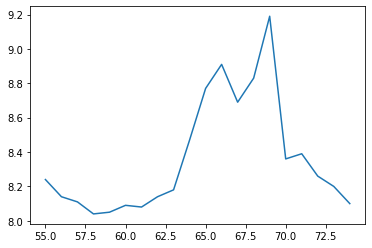

In [12]:
s = 55
m_data = stock.iloc[s:s+20]
m_data['Close'].plot()

In [13]:
n_visible_data = 10
xx_data = m_data.values
xx_data[n_visible_data:] = 0
o = {
    'price': xx_data,
    'pos'  : [0,0]
}
#print(o)

In [154]:
from sklearn.preprocessing import MinMaxScaler
from tf_agents.trajectories import time_step as ts

def convertDataToTimeStep(data, step_type):
    
    # scale price data
    data['price'] = MinMaxScaler().fit_transform(data['price']).astype(np.float32)

    #create time_step
    st = tf.constant(np.array(np.array([step_type], dtype=np.int32)))
    rw = tf.constant(np.array(np.array([0], dtype=np.float32)))
    ds = tf.constant(np.array(np.array([0], dtype=np.float32)))
    
    ts_obs = {}
    for key, value in data.items():
        ts_obs[key] = tf.expand_dims(tf.convert_to_tensor(value), axis=0)
    
    t = ts.TimeStep(st, rw, ds, ts_obs)

    #print(t)

    return t


def runPolicy(t, _policy, _policy_state):
    if( t.step_type.numpy()[0] == 0):
        _policy_state = _policy.get_initial_state(1)
    #_policy_state = _policy.get_initial_state(1)

    a, _policy_state, _ = _policy.action(t, _policy_state)

    return a, _policy_state
        

In [155]:
_policy = saved_policy
_policy_state = _policy.get_initial_state(1)

In [156]:
n_visible_data = 10
xx_data = m_data.values
xx_data[n_visible_data:] = 0
o = {
    'price': xx_data,
    'pos'  : [0,0]
}
t = convertDataToTimeStep(o, 0)
a, _policy_state = runPolicy(t, _policy, _policy_state)
a.numpy()[0]

2

In [157]:
n_visible_data = 10
pos = [0,0]
isPosOpen = False
for i in range(10):
    xx_data = m_data.values
    xx_data[n_visible_data+i:] = 0
    o = {
        'price': xx_data,
        'pos'  : pos
    }
    if(i == 0):
        t = convertDataToTimeStep(o, 0)
    elif(i == 9):
        t = convertDataToTimeStep(o, 2)
    else:
        t = convertDataToTimeStep(o, 1)

    #print(t)

    a, _policy_state = runPolicy(t, _policy, _policy_state)

    print('action: {} [{}] -> step_type: {}'.format(a.numpy(), srtAction(a.numpy()[0], isPosOpen), t.step_type.numpy()))

    if a == 1:
        pos[0] = 1
    elif a == 2:
        pos[1] = 1
    elif a == 3:
        pos[0] = 0
        pos[1] = 0

    if isPosOpen == True:
        if a == 3:
            isPosOpen = False
    else:
        if a == 1 or a == 2:
            isPosOpen = True

    #print('action',a.numpy()[0])

action: [2] [Sell] -> step_type: [0]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [3] [Close] -> step_type: [1]
action: [2] [Sell] -> step_type: [1]
action: [3] [Close] -> step_type: [2]


,High,Low,Open,Close,Volume
55,8.24,8.06,8.09,8.24,14044600
56,8.32,8.13,8.27,8.14,9684600
57,8.18,8.09,8.17,8.11,9203300
58,8.11,7.95,8.04,8.04,10784500
59,8.08,7.93,8.00,8.05,8493000
60,8.17,8.05,8.07,8.09,6138100
61,8.15,8.06,8.10,8.08,6926400
62,8.15,8.10,8.10,8.14,6213500
63,8.19,8.05,8.14,8.18,7971200
64,8.55,8.39,8.44,8.47,21152900


In [158]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

_policy = saved_policy
_policy_state = _policy.get_initial_state(1)

class SmaCross(Strategy):
    def init(self):
        self.counter = 0
        self.price_data = np.zeros((20,5))
        self.pos = [0, 0]
        self.collet_number = 10
        self.max_number = 20
        self.isPosOpen = False
        self._policy_state = _policy.get_initial_state(1)

        pass

    def next(self):

        if (self.counter < self.max_number):
            x = np.array([self.data.High[-1], self.data.Low[-1], self.data.Open[-1], self.data.Close[-1], self.data.Volume[-1]])
            self.price_data[self.counter] = x.copy()

        if(self.counter >= self.collet_number):
            #print(self.counter)
            o = {
                'price': self.price_data,
                'pos'  : self.pos
                }
            
            if(self.counter == self.collet_number+1):
                t = convertDataToTimeStep(o, 0)
            elif(self.counter == self.max_number):
                t = convertDataToTimeStep(o, 2)
            else:
                t = convertDataToTimeStep(o, 1)

            #print(t)
            a, self._policy_state = runPolicy(t, _policy, self._policy_state)

            print('action: {} [{}] -> step_type: {}'.format(a.numpy(), srtAction(a.numpy()[0], self.isPosOpen), t.step_type.numpy()))

            if a == 1:
                self.pos[0] = 1
            elif a == 2:
                self.pos[1] = 1
            elif a == 3:
                self.pos[0] = 0
                self.pos[1] = 0
                self.position.close()
                print('close')

            if self.isPosOpen == True:
                if a == 3:
                    self.isPosOpen = False
            else:
                if a == 1 or a == 2:
                    self.isPosOpen = True
                    if a==1:
                        self.buy()
                        print('buy')
                    if a==2:
                        self.sell()
                        print('sell')
                
        self.counter +=1

        if(self.counter > self.max_number):
           self.counter = 0 
           self.price_data[:self.collet_number] = self.price_data[-self.collet_number:]
           self.price_data[self.collet_number:] = 0
           self.pos = [0, 0]
           self.isPosOpen = False
        
#bt.plot()

In [159]:
import pandas_datareader as pdr
begin_data = datetime.datetime(2010, 2, 1)
end_data = datetime.datetime(2020, 4, 1)

pd_data = pdr.get_data_yahoo('SPY', start=begin_data, end=end_data)

In [160]:
pd_data = pd_data[['Open','High','Low','Close','Volume']]
pd_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-02-01,108.150002,109.070000,107.500000,109.059998,187865000.0
2010-02-02,109.260002,110.589996,108.879997,110.379997,216327900.0
2010-02-03,109.879997,110.480003,109.510002,109.830002,172730700.0
2010-02-04,108.980003,109.029999,106.419998,106.440002,356715700.0
2010-02-05,106.559998,106.879997,104.580002,106.660004,493585800.0


In [161]:
bt = Backtest(pd_data, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
stats

ose -> Skip] -> step_type: [1]
close
action: [3] [Close -> Skip] -> step_type: [2]
close
action: [2] [Sell] -> step_type: [1]
sell
action: [2] [Sell -> SkipTrue] -> step_type: [0]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [3] [Close] -> step_type: [1]
close
action: [3] [Close -> Skip] -> step_type: [1]
close
action: [3] [Close -> Skip] -> step_type: [1]
close
action: [3] [Close -> Skip] -> step_type: [2]
close
action: [2] [Sell] -> step_type: [1]
sell
action: [2] [Sell -> SkipTrue] -> step_type: [0]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [2] [Sell -> SkipTrue] -> step_type: [1]
action: [3] [Close] -> step_type: [1]
c

Start                     2010-02-01 00:00:00
End                       2020-04-01 00:00:00
Duration                   3712 days 00:00:00
Exposure Time [%]                     43.2422
Equity Final [$]                      5542.21
Equity Peak [$]                         10442
Return [%]                           -44.5779
Buy & Hold Return [%]                 125.701
Return (Ann.) [%]                    -5.64417
Volatility (Ann.) [%]                 9.39746
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -50.1969
Avg. Drawdown [%]                    -11.9624
Max. Drawdown Duration     3562 days 00:00:00
Avg. Drawdown Duration      739 days 00:00:00
# Trades                                  165
Win Rate [%]                          38.7879
Best Trade [%]                        6.83612
Worst Trade [%]                      -6.27648
Avg. Trade [%]                    

In [153]:
bt.plot()